In [10]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from imblearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

In [11]:
from sklearn.model_selection import train_test_split
heart = pd.read_csv('heart.csv')
y = heart.pop('target')
X = heart.values
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 1/5 , random_state = 0)


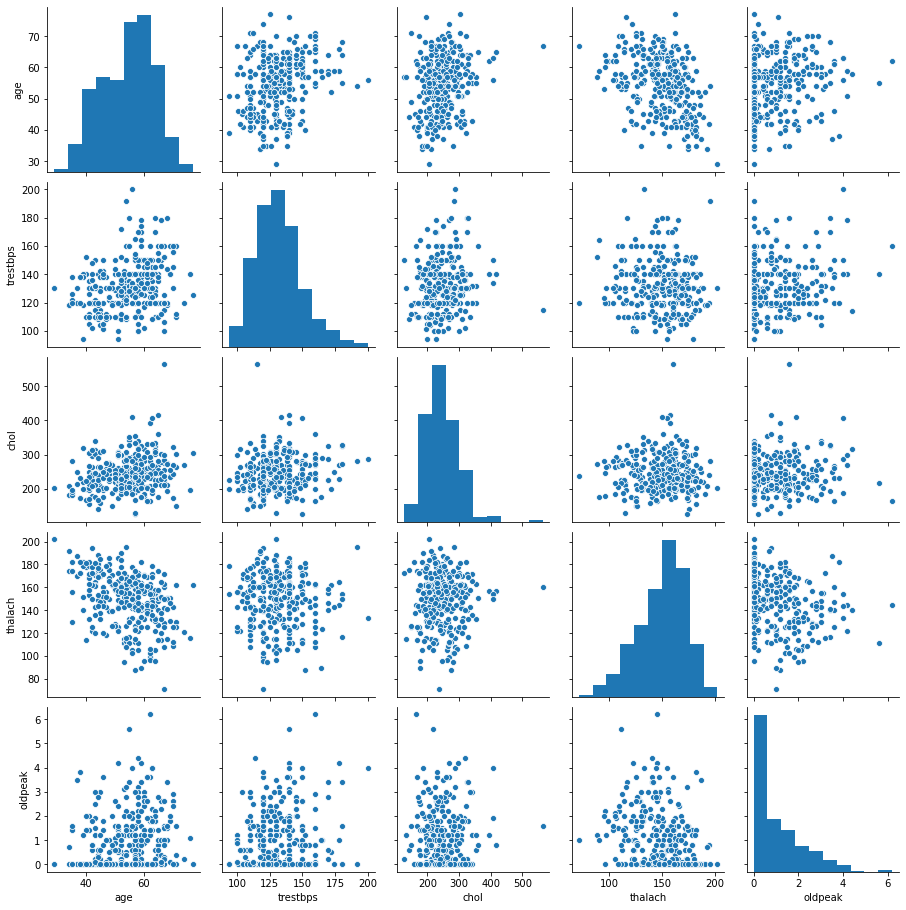

In [12]:
import seaborn as sns
sns.pairplot(heart[['age','trestbps','chol',
                    'thalach','oldpeak']])
plt.savefig('pairs.png')

In [13]:
heart[['age','trestbps','chol','thalach','oldpeak']].describe().to_excel('descr2.xlsx')

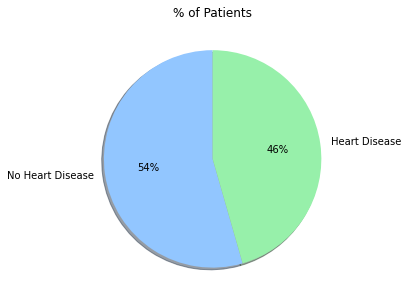

In [14]:
import matplotlib.style
import matplotlib as mpl
import seaborn as sns

mpl.style.use('seaborn-pastel')

fig , (ax1)  = plt.subplots(1,figsize = (10,5))

ax1.pie(y.value_counts(),
        labels = ['No Heart Disease','Heart Disease'],
        autopct = '%1.0f%%' ,
        shadow = True ,
        startangle = 90 )

ax1.set_title('% of Patients')

plt.savefig('pir.png',edgecolor = 'white',transparent = True)

Importing the relevant modules, then calculating the cross val and accuracy scores

In [15]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

In [16]:
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer, KNNImputer

xgb = XGBClassifier()

xgb_pipe = Pipeline(steps = [
    ('imputer',KNNImputer(missing_values = np.nan)),
    ('scaler','passthrough'),
    ('classifier',xgb)
])

In [17]:
param_grid = {'scaler':[StandardScaler(),MinMaxScaler()],
              'classifier__learning_rate':[0.05,0.1,0.2],
              'classifier__n_estimators':[50,100,150],
              'classifier__max_depth':[2,3,5,7],
             }


In [18]:
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

folds = KFold(n_splits = 10, shuffle = True)

grid_search = GridSearchCV(xgb_pipe,param_grid,cv = folds ,verbose = 0,n_jobs = -1)
grid_search = grid_search.fit(X_train,y_train)

In [19]:
y_pred = grid_search.predict(X_test)
print('Accuracy score for test data {0:.3f}'.format(accuracy_score(y_test,y_pred)))

Accuracy score for test data 0.820


In [20]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc

In [21]:
confusion = confusion_matrix(y_test, y_pred)
print("Confusion matrix:\n{}".format(confusion)) 

Confusion matrix:
[[20  7]
 [ 4 30]]


Normalized confusion matrix
[[0.74 0.26]
 [0.12 0.88]]


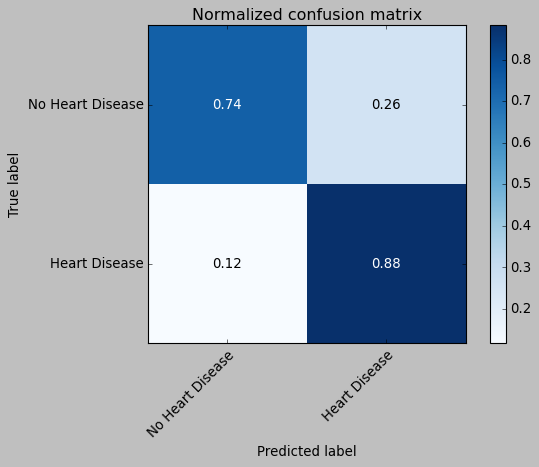

In [22]:

from sklearn.utils.multiclass import unique_labels
mpl.style.use('classic')

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=['No Heart Disease','Heart Disease'], normalize=True,
                      title='Normalized confusion matrix')

plt.savefig('confusion.png',edgecolor = 'white',transparent = True)

In [23]:
report = classification_report(y_test, y_pred, target_names = ['No Heart Disease','Heart Disease'])
print("Classification Report:\n{}".format(report)) 

Classification Report:
                  precision    recall  f1-score   support

No Heart Disease       0.83      0.74      0.78        27
   Heart Disease       0.81      0.88      0.85        34

        accuracy                           0.82        61
       macro avg       0.82      0.81      0.81        61
    weighted avg       0.82      0.82      0.82        61



In [33]:
import numpy as np
import pandas as pd

heart_train = pd.read_csv('heart-train.csv')
heart_test = pd.read_csv('heart-test.csv')

y_train = heart_train.pop('DEATH_EVENT')
X_train = heart_train.values

y_test = heart_test.pop('DEATH_EVENT')
X_test = heart_test.values

#### Selecting Best features

In [35]:


from sklearn.feature_selection import SelectKBest, mutual_info_classif

mi = dict()
i_scores = mutual_info_classif(X_train,y_train)

for i,j in zip(heart.columns,i_scores):
    mi[i] = j
    
df = pd.DataFrame.from_dict(mi,orient = 'index',columns = ['I-Gain'])
df.sort_values('I-Gain',ascending = False,inplace = True)

df

,I-Gain
ca,0.218245
thalach,0.129422
chol,0.112965
age,0.074771
trestbps,0.037979
oldpeak,0.026224
fbs,0.023240
exang,0.013711
slope,0.001913
sex,0.000000


The information gain criteria shows us that time is gives the most information gain and anaemia,plaelets, sex and smoking give us the least

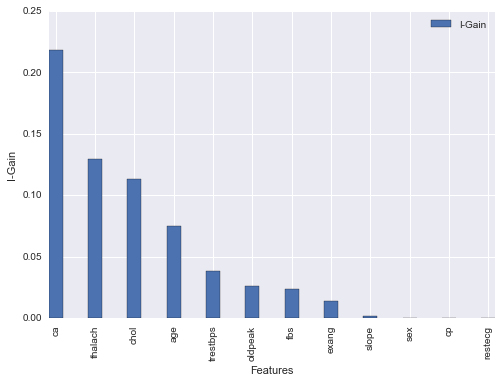

In [36]:
import matplotlib.pyplot as plt
%matplotlib inline
mpl.style.use('seaborn')

n = len(df.index)
rr = range(1,n)
fig, ax = plt.subplots()
ax.bar(df.index, df["I-Gain"], label='I-Gain',width=.35)
ax.set_xticklabels(list(df.index), rotation = 90)
ax.set_xlabel('Features')
ax.set_ylabel('I-Gain')
ax.legend()

plt.savefig('Information Gain.png',transparent = True)

If we base the feature selection on Information Gain, we see 'time' has the highest value.

This tells us that time is an important feature to include in a feature subset that will generalize
well for this task.

After time, there is a big drop off in information gain for the other variables,
and there is another big drop after the third feature(serum creatinine).

After age, the information gain from the remaining features is very low. 
They are unlikley to be worth including as they are likely to just introduce noise into the 
classifier, which would reduce accuracy. 

The last 3 features provide 0 information gain and therefore are not expected to be useful for
a feature subset that generalizes well.

Select k best features

In [26]:
grid_search.best_params_

{'classifier__learning_rate': 0.05,
 'classifier__max_depth': 3,
 'classifier__n_estimators': 50,
 'scaler': StandardScaler()}

In [27]:
kwargs = {'learning_rate': 0.05,
 'max_depth': 2,
 'n_estimators': 50,}
xgb = XGBClassifier(**kwargs)

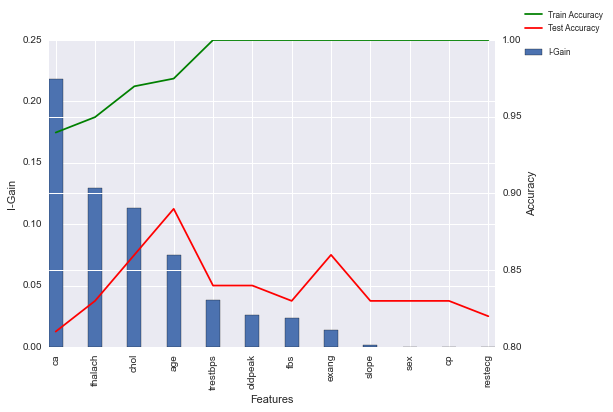

In [37]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_selection import SelectKBest

#xgb = XGBClassifier(**kwargs)
xgb = GradientBoostingClassifier()

folds = KFold(n_splits = 8, shuffle = True)
train_acc_scores = []
test_acc_scores = []

for kk in range(1,X_train.shape[1]+1):
    transformer = SelectKBest(mutual_info_classif,k=kk).fit(X_train,y_train)
    
    X_train_trans = transformer.transform(X_train)
    X_test_trans = transformer.transform(X_test)
    
    #grid_search = GridSearchCV(xgb,param_grid,cv = folds,verbose = 0,n_jobs = -1)
    model = xgb.fit(X_train_trans,y_train)
    y_pred_train = model.predict(X_train_trans)
    y_pred_test = model.predict(X_test_trans)
    
    train_acc_scores.append(accuracy_score(y_train,y_pred_train))
    test_acc_scores.append(accuracy_score(y_test,y_pred_test))
    #print(100*kk/X_train.shape[1],'%')
    
df['Train Accuracy'] = train_acc_scores
df['Test Accuracy'] = test_acc_scores

import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties

n = len(df.index)
rr = range(1,n)
fig, ax = plt.subplots()
ax2 = ax.twinx()
ax.bar(df.index, df["I-Gain"], label='I-Gain',width=.35)

ax2.plot(df.index, df["Train Accuracy"], color = 'g',label='Train Accuracy')
ax2.plot(df.index, df["Test Accuracy"], color = 'r',label='Test Accuracy')

ax.set_xticklabels(list(df.index), rotation = 90)
ax.set_xlabel('Features')
ax.set_ylabel('I-Gain')
ax2.set_ylabel('Accuracy')
#ax.legend(loc = 9)
#ax2.leg0end(loc = 7)
fontP = FontProperties()
fontP.set_size('smaller')
ax.legend( bbox_to_anchor = (1.05,1),loc = 'upper left',prop = fontP)
ax2.legend( bbox_to_anchor = (1.05,1),loc = 'lower left',prop = fontP)

plt.savefig('acc.jpeg' ,bbox_inches = 'tight', transparent = True)


The code above finds the best parameters for the gradient boosting classifer within
the param_grid values, for each value of k.

The train and test accuracy are then calculated for each k and then added to the dataframe df.

The above plot shows the test(green) and train(red) accuracy for each of the feature subsets.

A feature subset of 'time', 'ejection_fraction' and 'serum_creatinine' appears to generalize
very well, giving a test accuracy score of ~89% using only 3 features, which is higher than the
train set accuracy.

If he training accuracy was higher than the testing accuracy, this would be an example of overfitting. This would mean the model has not been generalized well.

The train accuracy is considerabley higher than the testing. This could be due to the testing data containing 'clean' data with only small amounts of noise.

